<a href="https://colab.research.google.com/github/a01247291/Proyecto-de-MIT/blob/main/Health_Ranking_Predictor_MIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Health Ranking Predictor

In [40]:
# --- BLOCK 1: IMPORTING LIBRARIES ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

print("Libraries loaded correctly.")

Libraries loaded correctly.


In [41]:
# --- BLOCK 2: DATA LOADING AND CLEANING ---

# 1. Load file
file_path = '/content/drive/MyDrive/Colab Notebooks/Desarrollo de Proyectos/Proyecto MIT/Shopper Survey (MX 25)_November 26, 2025_14.33.csv'
df = pd.read_csv(file_path)

# 2. Initial filters (Remove junk and unfinished surveys)
df = df.drop([0, 1]).reset_index(drop=True)
df = df[df['Finished'] == 'True']

# 3. Select and Rename columns
df_clean = df[['Q25_1', 'Q25_2', 'Q25_3', 'Q25_4', 'Q16', 'Q17']].copy()
df_clean.columns = ['Price', 'Flavor', 'Health', 'Availability', 'Age', 'Gender']

# 4. Age Cleaning (Fix hyphens and Numeric Map)
# IMPORTANT: We define age_map here to use it throughout the notebook
df_clean['Age'] = df_clean['Age'].str.replace('–', '-', regex=False) # Fix long hyphen
mapa_edad = {
    'Under 20': 0, '20-29': 1, '30-39': 2,
    '40-49': 3, '50-59': 4, '60-69': 5, '70 and over': 6
}
df_clean['Edad_Num'] = df_clean['Age'].map(mapa_edad)

# 5. Gender Cleaning (Dummy Variables)
df_clean['Male'] = (df_clean['Gender'] == 'Male').astype(int)
df_clean['Female'] = (df_clean['Gender'] == 'Female').astype(int)

# 6. Convert Rankings to Numbers
cols_num = ['Price', 'Flavor', 'Health', 'Availability']
for col in cols_num:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# 7. Final Cleaning (Remove NaNs)
# We create the 'df_final' variable that we will use from now on
df_final = df_clean.dropna()

print(f"Clean database generated in variable 'df_final'.")
print(f"Total valid surveys for analysis: {len(df_final)}")
display(df_final.head())

Clean database generated in variable 'df_final'.
Total valid surveys for analysis: 1131


,Price,Flavor,Health,Availability,Age,Gender,Edad_Num,Male,Female
7,2,3,4,1,20-29,Male,1.0,1,0
8,3,1,2,4,20-29,Male,1.0,1,0
9,3,1,4,2,20-29,Male,1.0,1,0
10,2,1,3,4,20-29,Female,1.0,0,1
11,2,3,4,1,30-39,Female,2.0,0,1


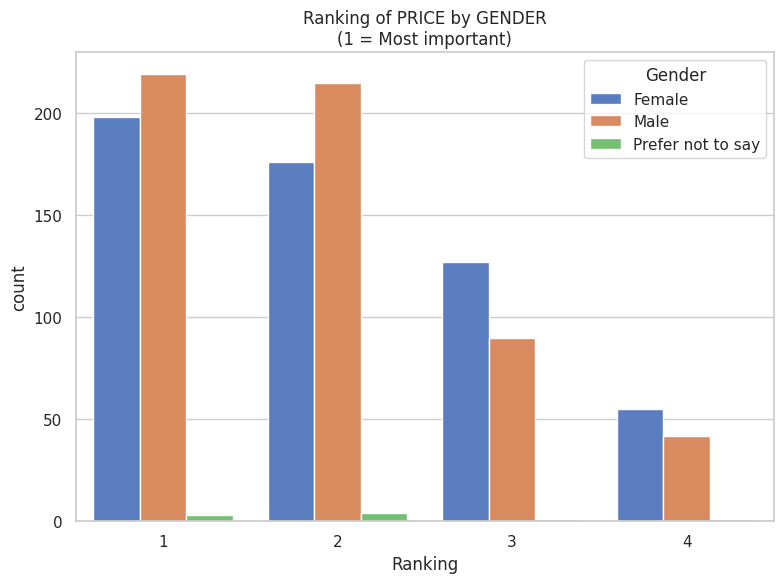

----------------------------------------------------------------------------------------------------


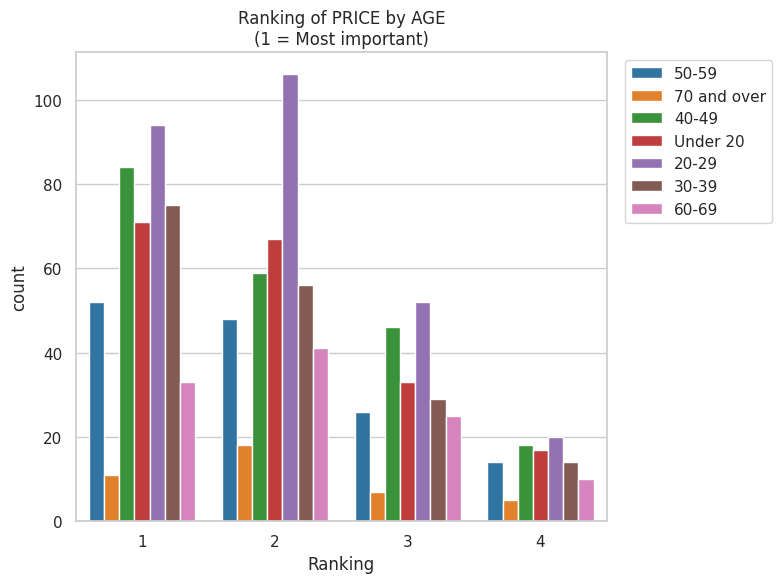

----------------------------------------------------------------------------------------------------


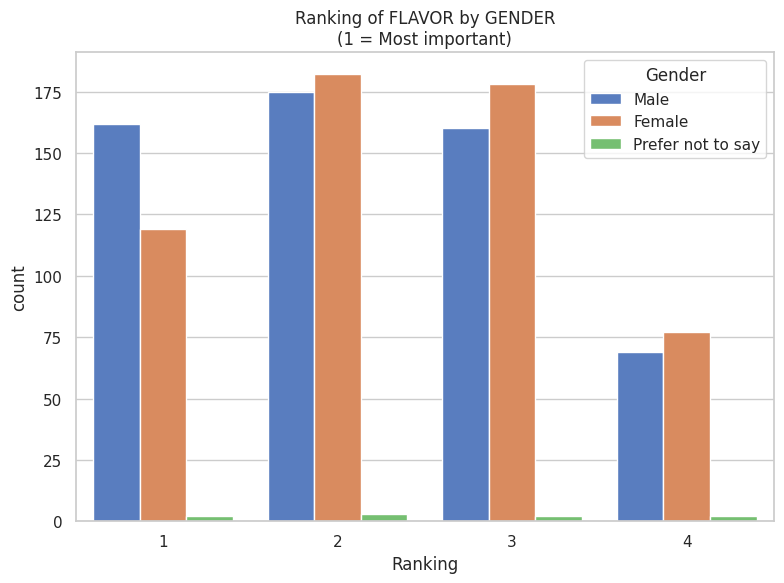

----------------------------------------------------------------------------------------------------


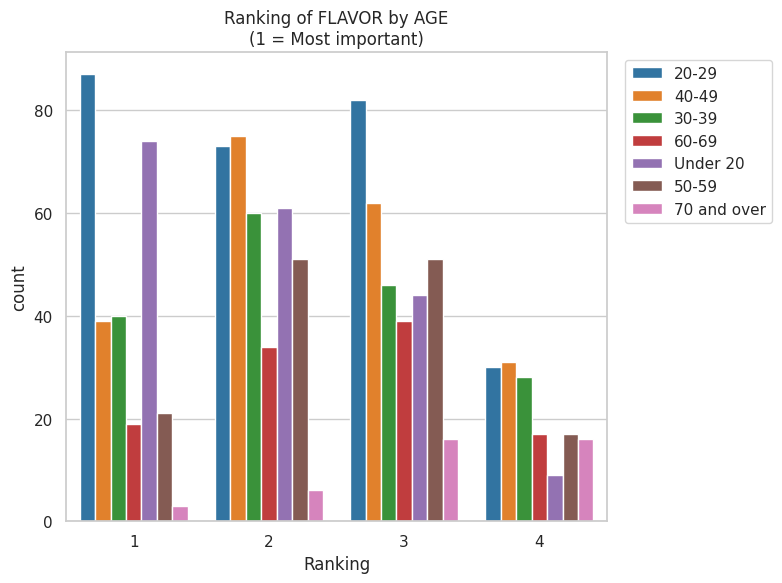

----------------------------------------------------------------------------------------------------


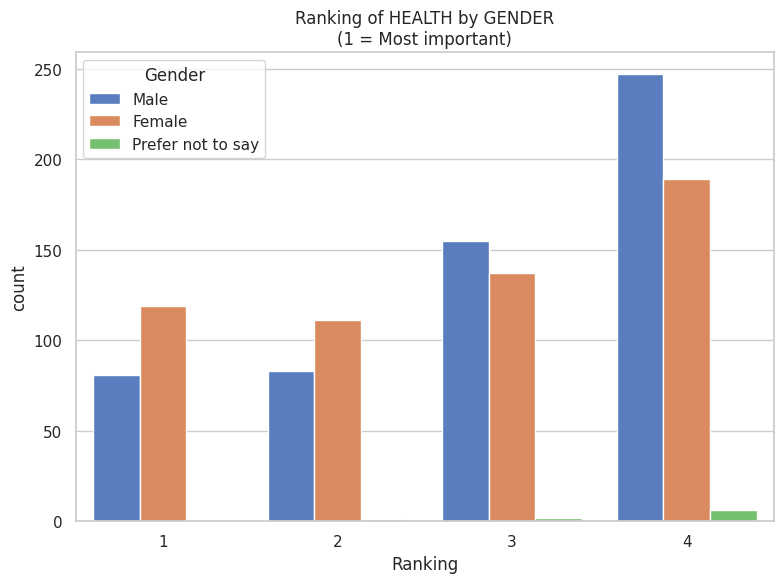

----------------------------------------------------------------------------------------------------


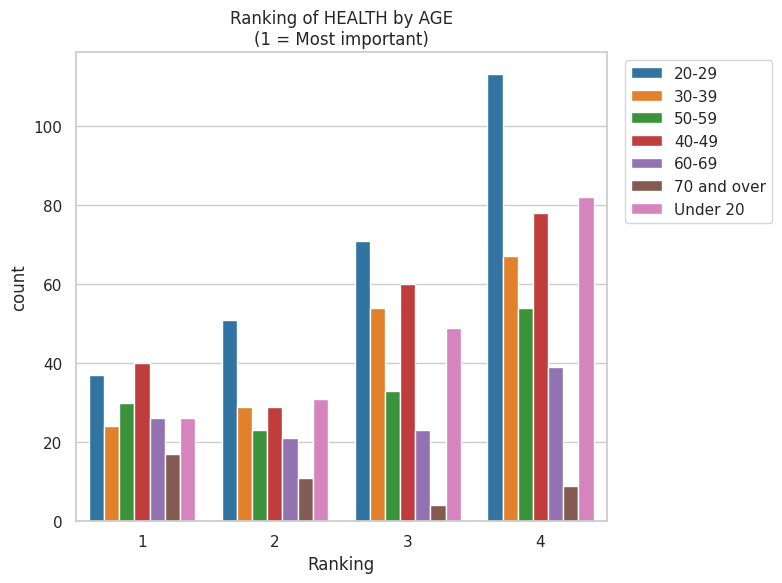

----------------------------------------------------------------------------------------------------


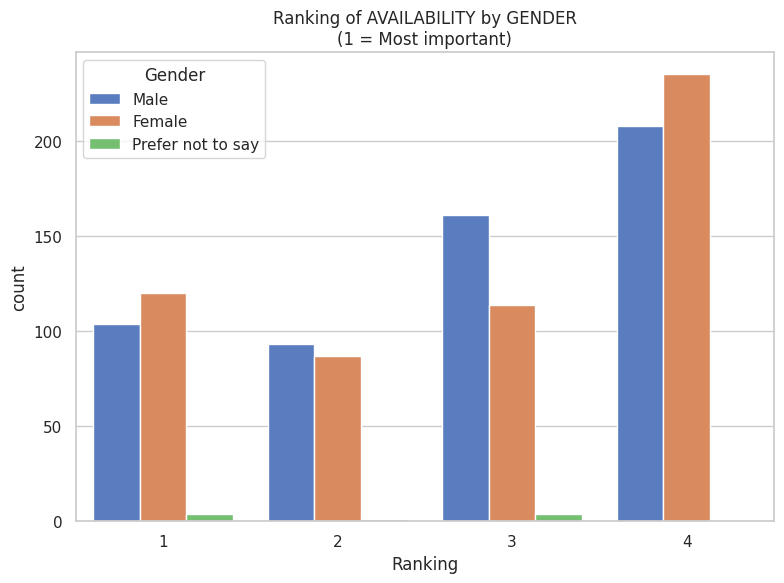

----------------------------------------------------------------------------------------------------


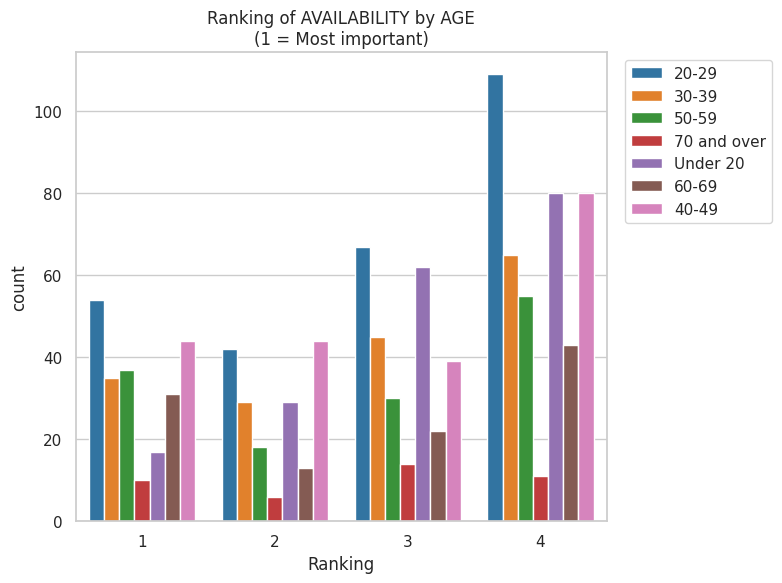

----------------------------------------------------------------------------------------------------


In [42]:
# --- BLOCK 3: GENERATE GRAPHS (HISTOGRAMS) ---
# We use df_final created in the previous cell

# Prepare data for plotting (Melt)
df_melted = df_final.melt(id_vars=['Age', 'Gender'],
                          value_vars=['Price', 'Flavor', 'Health', 'Availability'],
                          var_name='Attribute',
                          value_name='Ranking')

sns.set_theme(style="whitegrid")

# Loop to generate the 8 individual graphs
atributos = ['Price', 'Flavor', 'Health', 'Availability']

for att in atributos:
    data_temp = df_melted[df_melted['Attribute'] == att]

    # Plot by GENDER
    plt.figure(figsize=(8, 6))
    sns.countplot(data=data_temp, x="Ranking", hue="Gender", palette="muted")
    plt.title(f'Ranking of {att.upper()} by GENDER\n(1 = Most important)')
    plt.tight_layout()
    plt.show()

    print("-" * 100)

    # Plot by AGE
    plt.figure(figsize=(8, 6))
    sns.countplot(data=data_temp, x="Ranking", hue="Age", palette="tab10")
    plt.title(f'Ranking of {att.upper()} by AGE\n(1 = Most important)')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    print("-" * 100)

Random Forest model trained.
Model accuracy in this test: 34.4%


/tmp/ipython-input-522749965.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  grafico = sns.barplot(data=importancias, x='Weight', y='Variable', palette='viridis')


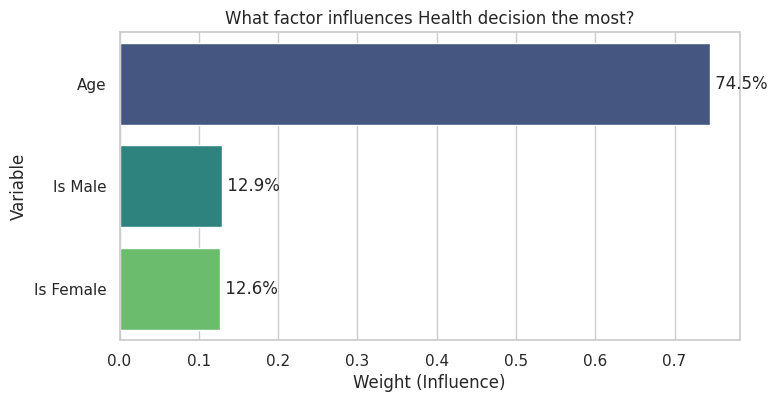

In [43]:
# --- BLOCK 4: AI MODEL TRAINING ---

# Define variables (X, y) using df_final
X = df_final[['Edad_Num', 'Male', 'Female']]
y = df_final['Health']

# Split data (Train/Test)
# Note: We remove random_state so that results vary a bit each time (more realistic)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train model
modelo_rf = RandomForestClassifier(n_estimators=100)
modelo_rf.fit(X_train, y_train)

# Result
acc = accuracy_score(y_test, modelo_rf.predict(X_test))
print(f"Random Forest model trained.")
print(f"Model accuracy in this test: {acc:.1%}")

# Importance Plot
importancias = pd.DataFrame({
    'Variable': ['Age', 'Is Male', 'Is Female'],
    'Weight': modelo_rf.feature_importances_
}).sort_values('Weight', ascending=False)

plt.figure(figsize=(8, 4))
grafico = sns.barplot(data=importancias, x='Weight', y='Variable', palette='viridis')
plt.title('What factor influences Health decision the most?')
plt.xlabel('Weight (Influence)')
# Add percentage labels
for index, row in importancias.iterrows():
    grafico.text(row.Weight, index, f" {row.Weight:.1%}", va='center')
plt.show()

In [44]:
# --- BLOCK 5: REGRESSION ANALYSIS ---

# Prepare variables for statsmodels
# Statsmodels requires us to explicitly add the constant (intercept)
X_reg = sm.add_constant(df_final[['Edad_Num', 'Male', 'Female']])
y_reg = df_final['Health']

# Fit model
modelo_ols = sm.OLS(y_reg, X_reg).fit()

print(modelo_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                 Health   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     11.56
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           1.83e-07
Time:                        02:54:51   Log-Likelihood:                -1714.9
No. Observations:                1131   AIC:                             3438.
Df Residuals:                    1127   BIC:                             3458.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6968      0.370      9.981      0.0

In [45]:
# --- BLOCK 6: INTERACTIVE PREDICTION CALCULATOR ---
# Instructions: Change the values of these two variables and click Play

usuario_edad = '30-39'   # Options: 'Under 20', '20-29', '30-39', '40-49', '50-59', '60-69', '70 and over'
usuario_sexo = 'Female'  # Options: 'Male', 'Female', 'Prefer not to say'

# ---------------------------------------------------------
# AUTOMATIC PROCESSING (DO NOT MODIFY)
# ---------------------------------------------------------

# 1. Create a small table with user data
entrada = pd.DataFrame({'Age': [usuario_edad], 'Gender': [usuario_sexo]})

# 2. Convert Age to Number (Using the map from Block 2)
entrada['Age'] = entrada['Age'].str.replace('–', '-', regex=False)
entrada['Edad_Num'] = entrada['Age'].map(mapa_edad)

# 3. Convert Gender to Dummies (1s and 0s)
entrada['Male'] = (entrada['Gender'] == 'Male').astype(int)
entrada['Female'] = (entrada['Gender'] == 'Female').astype(int)

# 4. Prediction
try:
    prediccion = modelo_rf.predict(entrada[['Edad_Num', 'Male', 'Female']])
    probs = modelo_rf.predict_proba(entrada[['Edad_Num', 'Male', 'Female']])

    print(f"--- RESULT FOR: {usuario_sexo}, {usuario_edad} ---")
    print(f"Predicted Ranking for Health: {prediccion[0]}")
    print(f"(Where 1 = Very Important and 4 = Not Important)")

    print("\nProbabilities by Ranking:")
    print(f"Ranking 1: {probs[0][0]:.1%}")
    print(f"Ranking 2: {probs[0][1]:.1%}")
    print(f"Ranking 3: {probs[0][2]:.1%}")
    print(f"Ranking 4: {probs[0][3]:.1%}")

except NameError:
    print("ERROR: Model 'modelo_rf' is not defined. Please run Block 4 first.")

--- RESULT FOR: Female, 30-39 ---
Predicted Ranking for Health: 3
(Where 1 = Very Important and 4 = Not Important)

Probabilities by Ranking:
Ranking 1: 17.8%
Ranking 2: 18.6%
Ranking 3: 32.7%
Ranking 4: 30.9%
